In [7]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import wandb
import hydra
import omegaconf
from omegaconf import DictConfig, OmegaConf
import os

import sklearn
from sklearn.datasets import make_moons



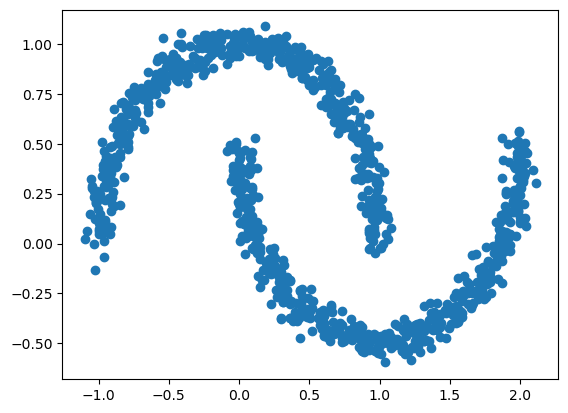

In [8]:
n_samples = 1000
datanoise = 0.05
data, _ = make_moons(n_samples, noise=datanoise)
data = torch.from_numpy(data).float()

plt.scatter(data[:, 0], data[:, 1])
plt.show()

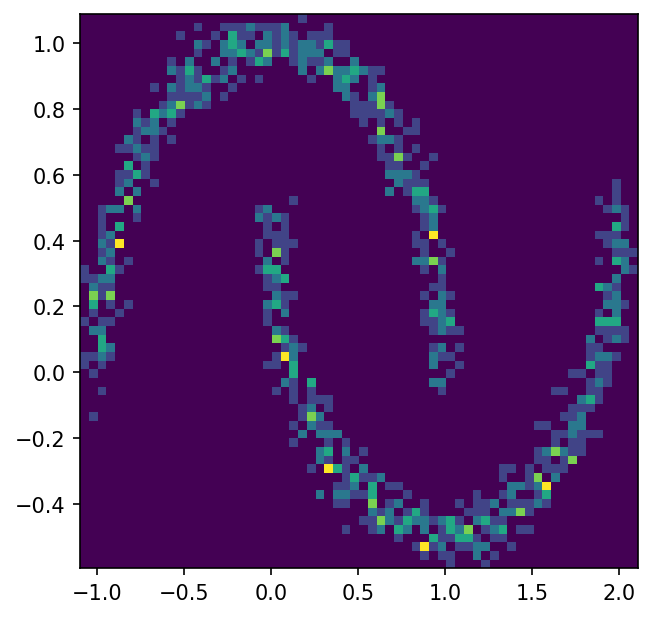

In [9]:
x = data

if isinstance(x, torch.Tensor):
        x = x.cpu().numpy()
plt.figure(figsize=(4.8, 4.8), dpi=150)
plt.hist2d(*x.T, bins=64)
plt.show()